In [1]:
import os
import os.path
import glob
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'paper-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from paper-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9700, 2048)

In [9]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 .....

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.9s


[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.918557, total=   9.7s
[CV] C=1000.0 ........................................................
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.913402, total=  12.8s
[CV] C=1000.0 ........................................................
[CV] ............................ C=0.1, score=0.904124, total=  20.4s
[CV] C=1000.0 ........................................................
[CV] ............................ C=0.1, score=0.903608, total=  22.4s
[CV] C=10000.0 .......................................................
[CV] ............................ C=0.1, score=0.901546, total=  22.5s
[CV] ........................... C=10.0, score=0.902062, total=  21.2s
[CV] C=10000.0 .......................................................
[CV] C=10000.0 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   25.6s


[CV] ............................ C=1.0, score=0.896392, total=  22.7s
[CV] C=100000.0 ......................................................
[CV] C=100000.0 ......................................................
[CV] C=100000.0 ......................................................
[CV] ........................... C=10.0, score=0.909278, total=  22.9s
[CV] C=100000.0 ......................................................
[CV] ........................... C=10.0, score=0.900000, total=  23.1s
[CV] C=100000.0 ......................................................
[CV] .......................... C=100.0, score=0.900515, total=  22.5s
[CV] ........................... C=10.0, score=0.892268, total=  23.2s
[CV] C=1000000.0 .....................................................
[CV] C=1000000.0 .....................................................
[CV] ........................... C=10.0, score=0.896392, total=  23.6s
[CV] C=1000000.0 .....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  25 out of  65 | elapsed:   31.3s remaining:   50.2s


[CV] .......................... C=100.0, score=0.894330, total=  21.7s
[CV] C=10000000.0 ....................................................
[CV] ......................... C=1000.0, score=0.906186, total=  22.1s
[CV] C=100000000.0 ...................................................
[CV] ......................... C=1000.0, score=0.898454, total=  22.6s
[CV] C=100000000.0 ...................................................
[CV] ......................... C=1000.0, score=0.894845, total=  21.3s
[CV] C=100000000.0 ...................................................
[CV] ......................... C=1000.0, score=0.895876, total=  21.6s
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.902577, total=  21.9s
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.906186, total=  21.8s
[CV] C=1000000000.0 ..................................................


[Parallel(n_jobs=-1)]: Done  32 out of  65 | elapsed:   47.0s remaining:   48.4s


[CV] ........................ C=10000.0, score=0.898454, total=  22.8s
[CV] C=1000000000.0 ..................................................
[CV] ....................... C=100000.0, score=0.902577, total=  22.3s
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.895876, total=  22.6s
[CV] ....................... C=100000.0, score=0.898454, total=  22.2s
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.894845, total=  23.3s
[CV] C=1000000000.0 ..................................................
[CV] C=10000000000.0 .................................................
[CV] ...................... C=1000000.0, score=0.902577, total=  22.2s
[CV] C=10000000000.0 .................................................
[CV] ....................... C=100000.0, score=0.905670, total=  23.4s
[CV] ...................... C=1000000.0, score=0.898454, total=  22.0s
[CV] C

[Parallel(n_jobs=-1)]: Done  39 out of  65 | elapsed:   50.1s remaining:   33.4s


[CV] C=10000000000.0 .................................................
[CV] ....................... C=100000.0, score=0.895876, total=  23.5s
[CV] C=10000000000.0 .................................................
[CV] ...................... C=1000000.0, score=0.895876, total=  22.3s
[CV] ....................... C=100000.0, score=0.894845, total=  24.5s
[CV] ...................... C=1000000.0, score=0.905670, total=  23.7s
[CV] ..................... C=10000000.0, score=0.905670, total=  22.5s
[CV] ..................... C=10000000.0, score=0.902577, total=  23.7s
[CV] ...................... C=1000000.0, score=0.894845, total=  24.4s


[Parallel(n_jobs=-1)]: Done  46 out of  65 | elapsed:   52.8s remaining:   21.8s


[CV] ..................... C=10000000.0, score=0.898454, total=  24.3s
[CV] ..................... C=10000000.0, score=0.895876, total=  21.9s
[CV] ..................... C=10000000.0, score=0.893814, total=  22.7s
[CV] .................... C=100000000.0, score=0.899485, total=  21.4s
[CV] .................... C=100000000.0, score=0.902062, total=  22.0s
[CV] .................... C=100000000.0, score=0.908763, total=  20.7s


[Parallel(n_jobs=-1)]: Done  53 out of  65 | elapsed:   56.4s remaining:   12.8s


[CV] .................... C=100000000.0, score=0.893814, total=  17.8s
[CV] .................... C=100000000.0, score=0.895876, total=  16.3s
[CV] ................... C=1000000000.0, score=0.902062, total=  16.1s
[CV] ................... C=1000000000.0, score=0.908763, total=  16.6s
[CV] ................... C=1000000000.0, score=0.895876, total=  16.0s
[CV] ................... C=1000000000.0, score=0.899485, total=  17.6s
[CV] .................. C=10000000000.0, score=0.893814, total=  15.3s


[Parallel(n_jobs=-1)]: Done  60 out of  65 | elapsed:  1.1min remaining:    5.5s


[CV] ................... C=1000000000.0, score=0.893814, total=  17.2s
[CV] .................. C=10000000000.0, score=0.899485, total=  16.3s
[CV] .................. C=10000000000.0, score=0.902062, total=  17.0s
[CV] .................. C=10000000000.0, score=0.895876, total=  15.5s
[CV] .................. C=10000000000.0, score=0.908763, total=  16.6s


[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  1.1min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 0.01} - score: 0.9174


In [11]:
top_model.cv_results_

{'mean_fit_time': array([  9.80603123,  22.32270522,  22.70177131,  22.7173378 ,
         23.004075  ,  21.65361423,  22.43825336,  23.13161736,
         22.87945433,  22.99009156,  19.59774799,  16.70832319,  16.10484347]),
 'mean_score_time': array([ 0.10353985,  0.08010664,  0.08264842,  0.07800255,  0.07495999,
         0.06290617,  0.05837116,  0.04494538,  0.05245342,  0.0255084 ,
         0.05002508,  0.01869907,  0.04633288]),
 'mean_test_score': array([ 0.91742268,  0.90340206,  0.89979381,  0.9       ,  0.89969072,
         0.89948454,  0.89958763,  0.89948454,  0.89948454,  0.89927835,
         0.9       ,  0.9       ,  0.9       ]),
 'mean_train_score': array([ 0.99373711,  0.99994845,  0.99992268,  1.        ,  0.99997423,
         0.99997423,  0.99997423,  0.99997423,  0.99997423,  0.99997423,
         0.99994845,  0.99994845,  0.99994845]),
 'param_C': masked_array(data = [0.01 0.10000000000000001 1.0 10.0 100.0 1000.0 10000.0 100000.0 1000000.0
  10000000.0 100000000.0 

In [12]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
top_model = svm.SVC(top_model.best_params_['C'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(top_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

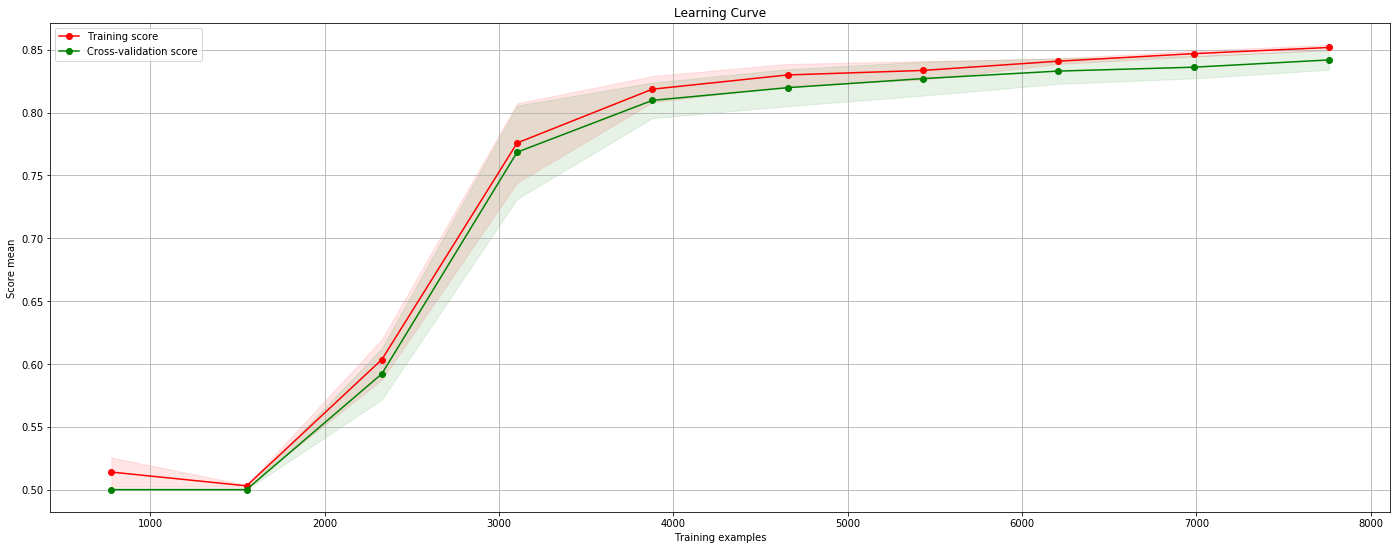

In [13]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()